<a href="https://colab.research.google.com/github/Mugdha1503/LETS-GZSL_MIT-BIH_With_Time-Series/blob/main/LETS_GZSL_MIT_BIH_With_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install antropy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 1.6 MB/s eta 0:00:00
  Created wheel for antropy: filename=antropy-0.1.6-py3-none-any.whl size=16880 sha256=f64205caaf9a757a7b3f2f61f55b4438b1a88ace231a22ac8d37811e6e2d7d30
  Stored in directory: /root/.cache/pip/wheels/98/22/06/e91d7bb213c7133d5e2eb34258623e1e19928d5f05e1ee6812
Successfully built antropy


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import os
import torch
# from antropy import app_entropy, sample_entropy
from statsmodels.tsa.stattools import adfuller
from scipy.stats import skew, kurtosis
import gc
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, auc
from sklearn.preprocessing import StandardScaler

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
%ls ..

MyDrive/


In [ ]:
seed = 420
np.random.seed(seed)

In [ ]:
df = pd.read_csv('/content/mitbih.csv')

In [ ]:
df.shape

(107885, 301)

In [ ]:
df = df.sample(frac=0.4,random_state=2)

In [ ]:
df.shape

(43154, 301)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df.iloc[:,:-1],df.iloc[:,-1],test_size=0.3,random_state=0)

In [ ]:
y_train.value_counts()

1    25154
3     2223
2     1861
4      725
5      244
Name: 1, dtype: int64

In [ ]:
y_test.value_counts()

1    10723
3      948
2      843
4      325
5      108
Name: 1, dtype: int64

In [ ]:
var = df.iloc[:,-1].value_counts()

<Axes: >

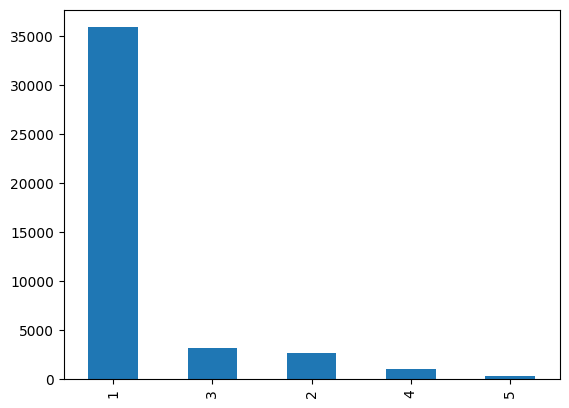

In [ ]:
var.plot(kind='bar')

In [ ]:
df_train = pd.concat([X_train,y_train],axis=1)

In [ ]:
df_train.shape

(30207, 301)

In [ ]:
df_test = pd.concat([X_test,y_test],axis=1)

In [ ]:
df_test.shape

(12947, 301)

In [ ]:
df = df.rename(columns = {'1':'Label'})

In [ ]:
df.Label.value_counts()

1    35877
3     3171
2     2704
4     1050
5      352
Name: Label, dtype: int64

In [ ]:
df.Label = df.Label-1

In [ ]:
df.Label.value_counts().sort_values(ascending=False)

0    35877
2     3171
1     2704
3     1050
4      352
Name: Label, dtype: int64

In [ ]:
class_labels = df.Label.value_counts().sort_values(ascending=False).index.tolist()

In [ ]:
class_labels

[0, 2, 1, 3, 4]

In [ ]:
y_count = df.Label.nunique()

In [ ]:
y_count

5

In [ ]:
df.columns = np.arange(len(df.columns))

In [ ]:
df = df.rename(columns = {300:'Label'})

In [ ]:
df.Label.value_counts()

0    35877
2     3171
1     2704
3     1050
4      352
Name: Label, dtype: int64

In [ ]:
def sample_tasks(df, test_split = 0.2):

    n_train = np.floor(y_count/2).astype(np.int32)
    if (y_count - n_train) %2 != 0:
      n_train = np.ceil(y_count/2).astype(np.int32)
    n_valtest = y_count - n_train
    n_val = np.floor(n_valtest/2).astype(np.int32)
    n_test = n_valtest - n_val

    train_labels = class_labels[:n_train]
    val_labels = class_labels[n_train: n_train+n_val]
    test_labels = class_labels[n_train+n_val: n_train+n_val+n_test]

    print(train_labels, val_labels, test_labels)

    df_train = df[df['Label'].isin(train_labels)].sample(frac=1, random_state=seed)
    df_val = df[df['Label'].isin(val_labels)].sample(frac=1, random_state=seed)
    df_test = df[df['Label'].isin(test_labels)].sample(frac=1, random_state=seed)

    n_tr = int(df_train.shape[0]*0.6)
    df_tr = df_train[:n_tr]

    y_train = df_tr['Label']
    X_train = df_tr.drop(['Label'], axis=1)

    df_rem = df_train[n_tr:]
    n_v = int(df_rem.shape[0]*0.5)
    y_val_seen = df_rem[:n_v]['Label']
    X_val_seen = df_rem[:n_v].drop(['Label'], axis=1)
    y_test_seen = df_rem[n_v:]['Label']
    X_test_seen = df_rem[n_v:].drop(['Label'], axis=1)

    n_se = int(df_val.shape[0]*0.8)
    y_val_unseen = df_val[:n_se]['Label']
    X_val_unseen = df_val[:n_se].drop(['Label'], axis=1)
    y_test_seen2 = df_val[n_se:]['Label']
    X_test_seen2 = df_val[n_se:].drop(['Label'], axis=1)

    y_test_unseen = df_test['Label']
    X_test_unseen = df_test.drop(['Label'], axis=1)

    return X_train, y_train, X_val_seen, y_val_seen, X_val_unseen, y_val_unseen, X_test_seen, \
        y_test_seen, X_test_seen2, y_test_seen2, X_test_unseen, y_test_unseen


In [ ]:
X_train, y_train, X_val_seen, y_val_seen, X_val_unseen, y_val_unseen, X_test_seen, \
        y_test_seen, X_test_unseen, y_test_unseen,  X_test_seen2, y_test_seen2, = \
        sample_tasks(df)

[0, 2, 1] [3] [4]


In [ ]:
y_test_seen2.value_counts()

4    352
Name: Label, dtype: int64

In [ ]:
X_train.shape

(25051, 300)

In [ ]:
X_train = np.expand_dims(X_train.values, axis=-1)
X_val_seen = np.expand_dims(X_val_seen.values, axis=-1)
X_val_unseen = np.expand_dims(X_val_unseen.values, axis=-1)
X_test_seen = np.expand_dims(X_test_seen.values, axis=-1)
X_test_unseen = np.expand_dims(X_test_unseen.values, axis=-1)
print(X_train.shape, X_val_seen.shape, X_val_unseen.shape, X_test_seen.shape, X_test_unseen.shape)

(25051, 300, 1) (8350, 300, 1) (840, 300, 1) (8351, 300, 1) (210, 300, 1)


In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
best_loss = np.inf
def es(model, loss):
  global best_loss
  if (loss<best_loss):
    best_loss = loss
    torch.save(model.net.state_dict(), './embedding_ECG_checkpoint.pt')

In [ ]:
%cd /content/drive/MyDrive/TS-GZSL/src

/content/drive/.shortcut-targets-by-id/1SpfYZ8YKWlxf-P0yGmyZHgL5Lo8x3Fna/TS-GZSL/src


In [ ]:
%ls ..

data/  Paper/  src/  ts2vec/


In [ ]:
sys.path.insert(1, '/content/drive/MyDrive/TS-GZSL/ts2vec')
import ts2vec
from ts2vec import TS2Vec

In [ ]:
enc = ts2vec.TS2Vec(
    output_dims=256,
    input_dims = 1,
    hidden_dims = 256,
    depth=6,
    batch_size=128,
    lr=1e-3,
    device = 'cuda:0',
    after_epoch_callback = es
)

In [ ]:
enc.net.load_state_dict(torch.load('./embedding_ECG_checkpoint.pt'))

<All keys matched successfully>

In [ ]:
X_train_embed = enc.encode(X_train, encoding_window='full_series')
X_val_seen_embed = enc.encode(X_val_seen, encoding_window='full_series')
X_val_unseen_embed = enc.encode(X_val_unseen, encoding_window='full_series')
X_test_seen_embed = enc.encode(X_test_seen, encoding_window='full_series')
X_test_unseen_embed = enc.encode(X_test_unseen, encoding_window='full_series')

In [ ]:
!pip install tsfresh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 7.4 MB/s eta 0:00:00


In [ ]:
from tsfresh import defaults
from tsfresh.feature_extraction import feature_calculators
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters
from tsfresh.utilities import dataframe_functions, profiling
from tsfresh.utilities.distribution import MapDistributor, MultiprocessingDistributor, DistributorBaseClass
from tsfresh.utilities.string_manipulation import convert_to_output_format

In [ ]:
from __future__ import absolute_import, division
from builtins import range
import itertools
from numpy.linalg import LinAlgError

from scipy.signal import welch, cwt, ricker, find_peaks_cwt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import linregress

In [ ]:
def autocorrelation_mean(x):
    var = np.var(x)
    n = len(x)
    if abs(var) < 10**-10:
        a = 0
    else:
        a = acf(x, adjusted=True, fft=n > 1250)[1:]
    return np.mean(a)

In [ ]:
def autocorrelation_median(x):
    var = np.var(x)
    n = len(x)
    if abs(var) < 10**-10:
        a = 0
    else:
        a = acf(x, adjusted=True, fft=n > 1250)[1:]
    return np.median(a)

In [ ]:
def autocorrelation_variance(x):
    var = np.var(x)
    n = len(x)
    if abs(var) < 10**-10:
        a = 0
    else:
        a = acf(x, adjusted=True, fft=n > 1250)[1:]
    return np.var(a)

In [ ]:
def autocorrelation(x, lag):
    if type(x) is pd.Series:
        x = x.values
    if len(x) < lag:
        return np.nan
    # Slice the relevant subseries based on the lag
    y1 = x[:(len(x)-lag)]
    y2 = x[lag:]
    # Subtract the mean of the whole series x
    x_mean = np.mean(x)
    # The result is sometimes referred to as "covariation"
    sum_product = np.sum((y1-x_mean)*(y2-x_mean))
    # Return the normalized unbiased covariance
    return sum_product / ((len(x) - lag) * np.var(x))

In [ ]:
!pip install nolds

In [ ]:
'''import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import pacf
import nolds

# Define the number_peaks function
def number_peaks(x, n):
    x = np.asarray(x)
    x_reduced = x[n:-n]

    res = None
    for i in range(1, n + 1):
        result_first = (x_reduced > np.roll(x, i)[n:-n])

        if res is None:
            res = result_first
        else:
            res &= result_first

        res &= (x_reduced > np.roll(x, -i)[n:-n])
    return sum(res)

def autocorrelation(x, lag):
    if type(x) is pd.Series:
        x = x.values
    if len(x) < lag:
        return np.nan
    # Slice the relevant subseries based on the lag
    y1 = x[:(len(x)-lag)]
    y2 = x[lag:]
    # Subtract the mean of the whole series x
    x_mean = np.mean(x)
    # The result is sometimes referred to as "covariation"
    sum_product = np.sum((y1-x_mean)*(y2-x_mean))
    # Return the normalized unbiased covariance
    return sum_product / ((len(x) - lag) * np.var(x))

def partial_autocorrelation(x, max_demanded_lag):
    n = len(x)
    if n <= 1:
        pacf_coeffs = [np.nan] * (max_demanded_lag + 1)
    else:
        if n <= max_demanded_lag:
            max_lag = n - 1
        else:
            max_lag = max_demanded_lag
        pacf_coeffs = list(pacf(x, method="ld", nlags=max_lag))
        pacf_coeffs = pacf_coeffs + [np.nan] * max(0, (max_demanded_lag - max_lag))
    return [("lag_{}".format(lag), pacf_coeffs[lag]) for lag in range(10)]

def get_semantic_features(X):
    mean_results = []
    median_results = []
    variance_results = []
    mins = []
    argmins = []
    maxs = []
    argmaxs = []
    means = []
    medians = []
    stddevs = []
    approx_entropies = []
    skews = []
    kurts = []
    #cid_ces = []
    partial_autocorr = []
    #number_of_peaks = []

    for i in range(X.shape[0]):
        x = X[i]
        mean_corr = autocorrelation(x, lag=10)
        median_corr = autocorrelation(x, lag=10)
        variance_corr = autocorrelation(x, lag=10)

        mean_results.append(mean_corr)
        median_results.append(median_corr)
        variance_results.append(variance_corr)

        mins.append(np.min(x))
        argmins.append(np.argmin(x))
        maxs.append(np.max(x))
        argmaxs.append(np.argmax(x))
        means.append(np.mean(x))
        medians.append(np.median(x))
        stddevs.append(np.std(x))

        if len(x) > 2:
            approx_entropies.append(nolds.sampen(x, emb_dim=2, tolerance=0.2))
        else:
            approx_entropies.append(np.nan)

        skews.append(skew(x))
        kurts.append(kurtosis(x))
       # cid_ces.append(cid_ce(x, 1))

        # Calculate and append partial autocorrelation
        partial_autocorr.append(partial_autocorrelation(x, max_demanded_lag=10))

        # Calculate the number of peaks and append as a feature
      #  num_peaks = number_peaks(x, n=5)  # You can set your desired value of 'n'
       # number_of_peaks.append(num_peaks)

    X_saved = pd.DataFrame({
        'autocorrelation_mean': mean_results,
        'autocorrelation_median': median_results,
        'autocorrelation_variance': variance_results,
        'mins': mins,
        'argmins': argmins,
        'maxs': maxs,
        'argmaxs': argmaxs,
        'means': means,
        'medians': medians,
        'stddevs': stddevs,
        'approx_entropies': approx_entropies,
        'skews': skews,
        'kurts': kurts,
       # 'cid_ce': cid_ces,
        'partial_autocorrelation': partial_autocorr,
       # 'number_of_peaks': number_of_peaks  # Add number of peaks as a feature
    })

    return X_saved.values

In [ ]:
from antropy import app_entropy, sample_entropy
from statsmodels.tsa.stattools import acf, pacf
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

def autocorrelation(x, lag=10):
    """
    Calculate autocorrelation for a given time series.

    Parameters:
    - x: 1D numpy array, the time series
    - lag: int, the lag for autocorrelation

    Returns:
    - float, autocorrelation value at the given lag
    """
    acf_values = acf(x, nlags=lag, fft=True)
    return acf_values[lag]

def partial_autocorrelation(x, max_demanded_lag=10):
    """
    Calculate partial autocorrelations for a given time series.

    Parameters:
    - x: 1D numpy array, the time series
    - max_demanded_lag: int, the maximum lag for partial autocorrelation

    Returns:
    - numpy array, partial autocorrelation values up to the specified lag
    """
    pacf_values = pacf(x, nlags=max_demanded_lag)
    return pacf_values

from sklearn.preprocessing import StandardScaler

def get_semantic_features(X):
    X = np.squeeze(X)
    X_saved = pd.DataFrame()

    X_saved['mins'] = np.min(X, axis=1)
    X_saved['argmins'] = np.argmin(X, axis=1)
    X_saved['maxs'] = np.max(X, axis=1)
    X_saved['argmaxs'] = np.argmax(X, axis=1)
    X_saved['means'] = np.mean(X, axis=1)
    X_saved['medians'] = np.median(X, axis=1)
    X_saved['stddevs'] = np.std(X, axis=1)

    # Autocorrelation based on mean, median, and variance
    X_saved['autocorr_mean'] = [autocorrelation(X[i] - np.mean(X[i])) for i in range(X.shape[0])]
    X_saved['autocorr_median'] = [autocorrelation(X[i] - np.median(X[i])) for i in range(X.shape[0])]
    X_saved['autocorr_variance'] = [autocorrelation(X[i] - np.var(X[i])) for i in range(X.shape[0])]

    # Partial autocorrelation
    max_demanded_lag = 10
    pacf_values = [partial_autocorrelation(X[i], max_demanded_lag) for i in range(X.shape[0])]
    for lag in range(1, max_demanded_lag + 1):
        X_saved[f'pacf_{lag}'] = [value[lag-1] for value in pacf_values]

    X_saved['approx_entropies'] = [app_entropy(X[i]) for i in range(X.shape[0])]
    X_saved['skews'] = skew(X, axis=1)
    X_saved['kurts'] = kurtosis(X, axis=1)

    # Feature Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_saved)

    return X_scaled


In [ ]:
X_train_semantic = get_semantic_features(X_train)
X_val_seen_semantic = get_semantic_features(X_val_seen)
X_val_unseen_semantic = get_semantic_features(X_val_unseen)
X_test_seen_semantic = get_semantic_features(X_test_seen)
X_test_unseen_semantic = get_semantic_features(X_test_unseen)

In [ ]:
X_train_concat = np.hstack((X_train_embed, X_train_semantic))
X_val_seen_concat = np.hstack((X_val_seen_embed, X_val_seen_semantic))
X_val_unseen_concat = np.hstack((X_val_unseen_embed, X_val_unseen_semantic))
X_test_seen_concat = np.hstack((X_test_seen_embed, X_test_seen_semantic))
X_test_unseen_concat = np.hstack((X_test_unseen_embed, X_test_unseen_semantic))

In [ ]:
X_train_concat.shape, X_val_seen_concat.shape, X_val_unseen_concat.shape, \
X_test_seen_concat.shape, X_test_unseen_concat.shape

((25051, 279), (8350, 279), (840, 279), (8351, 279), (210, 279))

In [ ]:
X_train_concat = np.expand_dims(X_train_concat, axis=-1)
X_val_seen_concat = np.expand_dims(X_val_seen_concat, axis=-1)
X_val_unseen_concat = np.expand_dims(X_val_unseen_concat, axis=-1)

In [ ]:
tot_len = y_val_seen.shape[0]+y_val_unseen.shape[0]
tot_len

9190

In [ ]:
conv_model_X = np.concatenate((X_val_seen_concat, X_val_unseen_concat), axis = 0)
conv_model_y = np.concatenate((y_val_seen, y_val_unseen), axis = 0)

In [ ]:
def harmonic(y_true, y_pred):
    I = tf.constant([0.,0.,1.,0.,1.])
    gamma = tf.constant([0.9])

    I_val_seen = tf.broadcast_to(I, (X_val_seen.shape[0], I.shape[0]))
    I_val_unseen = tf.broadcast_to(I, (X_val_unseen.shape[0], I.shape[0]))

    gamma_vec_val_seen = tf.broadcast_to(gamma, (X_val_seen.shape[0], I.shape[0]))
    gamma_vec_val_unseen = tf.broadcast_to(gamma, (X_val_unseen.shape[0], I.shape[0]))

    y_probs_val_seen = conv_model.model(X_val_seen_concat)
    y_probs_val_unseen = conv_model.model(X_val_unseen_concat)


    y_probs_val_seen_final = y_probs_val_seen - gamma_vec_val_seen*I_val_seen
    y_probs_val_unseen_final = y_probs_val_unseen - gamma_vec_val_unseen*I_val_unseen

    y_probs_val_seen_final = y_probs_val_seen_final.numpy()
    y_probs_val_unseen_final = y_probs_val_unseen_final.numpy()

    y_probs_val_seen_final[:, 4] = -999
    y_probs_val_unseen_final[:, 4] = -999

    y_probs_val_seen_final = tf.convert_to_tensor(y_probs_val_seen_final)
    y_probs_val_unseen_final = tf.convert_to_tensor(y_probs_val_unseen_final)

    y_preds_val_seen = tf.argmax(y_probs_val_seen_final, axis=1)
    y_preds_val_unseen = tf.argmax(y_probs_val_unseen_final, axis=1)


    y_val_seen_tensor = tf.convert_to_tensor(y_val_seen)
    y_val_unseen_tensor = tf.convert_to_tensor(y_val_unseen)

    acc_seen = tf.reduce_sum(tf.cast(tf.equal(y_preds_val_seen, y_val_seen), tf.int16))/y_val_seen.shape[0]
    acc_unseen = tf.reduce_sum(tf.cast(tf.equal(y_preds_val_unseen, y_val_unseen), tf.int16))/y_val_unseen.shape[0]

    h = 2*acc_seen*acc_unseen/(acc_seen+acc_unseen+1e-12)

    return h

In [ ]:
class ConvNet:

    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

        # Build model
        self.model = self.build_CNN_model()



    def build_CNN_model(self):

        tf.keras.backend.clear_session()
        input1 = tf.keras.layers.Input(shape=self.input_shape)

        # Convolutional Block 1
        conv1 = tf.keras.layers.Conv1D(filters=64,
                                       kernel_size=10,
                                       activation='relu',
                                       kernel_initializer= 'he_uniform')(input1)
        bn1 = tf.keras.layers.BatchNormalization()(conv1)
        drop1 = tf.keras.layers.Dropout(0.133)(bn1)
        pool1 = tf.keras.layers.MaxPooling1D(pool_size= 3)(drop1)
        # Convolutional Block 2
        conv2 = tf.keras.layers.Conv1D(filters=32,
                                       kernel_size=7,
                                       activation='relu',
                                       kernel_initializer= 'he_uniform')(pool1)
        bn2 = tf.keras.layers.BatchNormalization()(conv2)
        drop2 = tf.keras.layers.Dropout(0.308)(bn2)
        pool2 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop2)
        # Convolutional Block 3
        conv3 = tf.keras.layers.Conv1D(filters=256,
                                       kernel_size=5,
                                       activation='relu',
                                       kernel_initializer='he_uniform')(pool2)
        bn3 = tf.keras.layers.BatchNormalization()(conv3)
        drop3 = tf.keras.layers.Dropout(0.026)(bn3)
        pool3 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop3)

        #Convolutional Block 4
        conv4 = tf.keras.layers.Conv1D(filters=256,
                                       kernel_size=5,
                                       activation='relu',
                                       kernel_initializer='he_uniform')(pool3)
        bn4 = tf.keras.layers.BatchNormalization()(conv4)
        drop4 = tf.keras.layers.Dropout(0.266)(bn4)
        pool4 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop4)


        flat = tf.keras.layers.Flatten()(pool4)
        dense1 = tf.keras.layers.Dense(128,
                                       activation='relu',
                                       kernel_initializer='he_uniform')(flat)
        dense2 = tf.keras.layers.Dense(64,
                                       activation='relu',
                                       kernel_initializer='he_uniform')(dense1)
        # Output layer
        logits = tf.keras.layers.Dense(self.num_classes)(dense2)
        temp_calibration = tf.keras.layers.Lambda(lambda x: x/3.74)(logits)
        output1 = tf.keras.layers.Activation('softmax')(logits)

        model = tf.keras.Model(inputs=input1, outputs=output1, name = "CNN_Module")


        model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001),
                      metrics=[harmonic], run_eagerly=True)



        return model

    def fit(self, batch_size, epochs, x_train, y_train, x_val, y_val):

      es_callback_cnn = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=15, mode='min')
      mc_callback_cnn = tf.keras.callbacks.ModelCheckpoint('letsgzsl_ECG_weights.h5', monitor = 'val_loss',save_best_only=True, mode='min')

      # es_callback_cnn = tf.keras.callbacks.EarlyStopping(monitor = 'val_harmonic', patience=15, mode='max')
      # mc_callback_cnn = tf.keras.callbacks.ModelCheckpoint('letsgzsl_ECG_weights.h5', monitor = 'val_harmonic',save_best_only=True, mode='max')

      hist = self.model.fit(
          x_train,
          y_train,
          batch_size = batch_size,
          epochs = epochs,
          validation_data = (x_val, y_val),
          callbacks = [es_callback_cnn, mc_callback_cnn]
      )
      return hist


    def eval_metrics(self):
        self.model.load_weights('letsgzsl_ECG_weights.h5')
        I = np.array([0.,0.,1.,0.,1.])
        self.gamma_values = np.concatenate((np.arange(1e-1, 1, 2e-2), np.arange(0.99, 1.001, 1e-3) ))

        I_val_seen = np.broadcast_to(I, (X_val_seen_concat.shape[0], I.shape[0]))
        I_val_unseen = np.broadcast_to(I, (X_val_unseen_concat.shape[0], I.shape[0]))

        self.seen_accs = []
        self.unseen_accs = []
        self.hs = []

        for gamma in self.gamma_values:

            y_probs_val_seen = self.model.predict(X_val_seen_concat)
            y_probs_val_unseen = self.model.predict(X_val_unseen_concat)

            y_probs_val_seen_final = y_probs_val_seen - gamma*I_val_seen
            y_probs_val_unseen_final = y_probs_val_unseen - gamma*I_val_unseen

            y_probs_val_seen_final[:, 4] = -999
            y_probs_val_unseen_final[:, 4] = -999

            y_preds_val_seen = np.argmax(y_probs_val_seen_final, axis=1)
            y_preds_val_unseen = np.argmax(y_probs_val_unseen_final, axis=1)

            acc_seen = accuracy_score(y_val_seen, y_preds_val_seen)
            acc_unseen = accuracy_score(y_val_unseen, y_preds_val_unseen)
            h = 2*acc_seen*acc_unseen/(acc_seen+acc_unseen+1e-12)

            self.seen_accs.append(acc_seen)
            self.unseen_accs.append(acc_unseen)
            self.hs.append(h)

        self.seen_accs = np.array(self.seen_accs)
        self.unseen_accs = np.array(self.unseen_accs)
        self.hs = np.array(self.hs)

        self.best_h_idx = np.argmax(self.hs)
        self.busc = self.unseen_accs[self.best_h_idx]
        self.bsc = self.seen_accs[self.best_h_idx]
        self.best_gamma = self.gamma_values[self.best_h_idx]
        self.harmonic_val = self.hs[self.best_h_idx]


        idx = np.argsort(self.seen_accs)
        self.seen_accs = self.seen_accs[idx]
        self.unseen_accs = self.unseen_accs[idx]
        self.hs = self.hs[idx]



        self.ausuc_val = auc(self.seen_accs, self.unseen_accs)


In [ ]:
models = []
for i in range(3):
  conv_model = ConvNet(input_shape = X_train_concat.shape[1:], num_classes=y_count)
  models.append(conv_model)

In [ ]:
conv_model.model.summary()

Model: "CNN_Module"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 279, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 270, 64)           704       
                                                                 
 batch_normalization (Batch  (None, 270, 64)           256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 270, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 90, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 84, 32)            1

In [ ]:
#!export TF_FORCE_GPU_ALLOW_GROWTH=true

In [ ]:
from tqdm.notebook import tqdm

best_auc = -1
best_idx = -1
for i in tqdm(range(3)):
  if i < len(models):
    conv_model = models[i]
    conv_model.fit(
        batch_size=128,
        epochs=5,
        x_train=X_train_concat,
        y_train=y_train,
        x_val=conv_model_X,
        y_val=conv_model_y
    )

    conv_model.eval_metrics()
    if conv_model.ausuc_val > best_auc:
      best_auc = conv_model.ausuc_val
      best_idx = i

print("best auc = ", best_auc)
print("best index = ", best_idx)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/5
196/196 [==============================] - 54s 263ms/step - loss: 0.1770 - harmonic: 0.0000e+00 - val_loss: 1.4411 - val_harmonic: 0.0000e+00
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


196/196 [==============================] - 53s 270ms/step - loss: 0.0760 - harmonic: 0.0000e+00 - val_loss: 1.3316 - val_harmonic: 0.0000e+00
Epoch 3/5
196/196 [==============================] - 52s 266ms/step - loss: 0.0558 - harmonic: 0.0000e+00 - val_loss: 1.4309 - val_harmonic: 0.0000e+00
Epoch 4/5
196/196 [==============================] - 52s 267ms/step - loss: 0.0476 - harmonic: 0.0000e+00 - val_loss: 1.5450 - val_harmonic: 0.0000e+00
Epoch 5/5
27/27 [==============================] - 0s 16ms/step
Epoch 1/5
196/196 [==============================] - 55s 268ms/step - loss: 0.1687 - harmonic: 0.0000e+00 - val_loss: 1.1683 - val_harmonic: 0.0000e+00
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


196/196 [==============================] - 53s 270ms/step - loss: 0.0727 - harmonic: 7.2779e-05 - val_loss: 1.1074 - val_harmonic: 0.0000e+00
Epoch 3/5
196/196 [==============================] - 52s 267ms/step - loss: 0.0553 - harmonic: 0.0000e+00 - val_loss: 1.2399 - val_harmonic: 0.0000e+00
Epoch 4/5
196/196 [==============================] - 52s 268ms/step - loss: 0.0433 - harmonic: 0.0000e+00 - val_loss: 1.3402 - val_harmonic: 0.0000e+00
Epoch 5/5
27/27 [==============================] - 0s 16ms/step
Epoch 1/5
196/196 [==============================] - 54s 266ms/step - loss: 0.1649 - harmonic: 0.0000e+00 - val_loss: 2.0842 - val_harmonic: 0.0000e+00
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


196/196 [==============================] - 53s 269ms/step - loss: 0.0748 - harmonic: 0.0000e+00 - val_loss: 1.3805 - val_harmonic: 0.0000e+00
Epoch 3/5
196/196 [==============================] - 53s 271ms/step - loss: 0.0522 - harmonic: 0.0000e+00 - val_loss: 1.3748 - val_harmonic: 0.0000e+00
Epoch 4/5
196/196 [==============================] - 53s 269ms/step - loss: 0.0428 - harmonic: 0.0000e+00 - val_loss: 1.4418 - val_harmonic: 0.0000e+00
Epoch 5/5
27/27 [==============================] - 0s 16ms/step
best auc =  0.0
best index =  0


In [ ]:
print(models[best_idx].ausuc_val, models[best_idx].best_gamma, models[best_idx].harmonic_val, models[best_idx].bsc, models[best_idx].busc)

0.0 0.1 0.0 0.969940119760479 0.0


In [ ]:
models[best_idx].seen_accs

array([0.91161677, 0.96994012, 0.9702994 , 0.97053892, 0.97077844,
       0.97101796, 0.97125749, 0.97149701, 0.97185629, 0.97221557,
       0.97269461, 0.97269461, 0.97281437, 0.97329341, 0.97365269,
       0.97413174, 0.97461078, 0.97461078, 0.9748503 , 0.97508982,
       0.97556886, 0.97568862, 0.97568862, 0.97580838, 0.97628743,
       0.97628743, 0.97676647, 0.97700599, 0.97760479, 0.97796407,
       0.97820359, 0.97856287, 0.97916168, 0.97964072, 0.97964072,
       0.98023952, 0.9805988 , 0.9805988 , 0.98071856, 0.9811976 ,
       0.98131737, 0.98131737, 0.98167665, 0.98167665, 0.98179641,
       0.98191617, 0.98191617, 0.98203593, 0.98227545, 0.98239521,
       0.98239521, 0.98251497, 0.98251497, 0.98275449, 0.98299401,
       0.98311377])

In [ ]:
models[best_idx].unseen_accs

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])